In [10]:
using ProgressBars;

using LinearAlgebra, Plots, FFTW;

import LinearSolve as LS
using SparseArrays
using QuadGK;
using SpecialFunctions: gamma, loggamma, zeta

function central_diff_vec(vec, h)
    vec_ip1 = circshift(vec,-1)
    vec_im1 = circshift(vec,1)
    return (vec_ip1-vec_im1)/(2*h)
end

function create_mathcalF(x, U_n, PDL_matrix, M_n, Δt, h, ν)
    F_hM_n = F_func(M_n, h)
    δ_hx = central_diff_vec(x)
    Hδ_hx=H_func(δ_hx)
    return x-U_n+Δt*(ν*PDL_matrix*x+ Hδ_hx+F_hM_n)
end

#### For Powers of Discrete Laplacian ##################

function sum_weight(m, α, N_h, R)
    if m==0
        return 0
    end    
    weight_α = 0 
    for ν in -R:1:R
        weight_α += exp(loggamma(abs(m-N_h * ν)-α/2)-loggamma(abs(m-N_h * ν)+1+α/2))
    end 
    return weight_α
end

function asymp_weight_sum(m,α, N_h, R)
    if m==0
        return 0
    end
    asymp_weight_α = 0
    for ν in -R:1:R
        asymp_weight_α += 1/(abs(m-N_h*ν))^α 
    end
    return asymp_weight_α
end



function create_PDL_matrix(α, N_h, R) 
    println("Start create_PDL_matrix")
    PDL_matrix = zeros(Float64, N_h, N_h)
    
    c_α = 2^α * gamma((1+α)/2) /(sqrt(pi)*abs(gamma(-α/2)))
    zeta_term = 2*zeta(1+α)

    #Generate first row of PDL matrix and asymptotic terms
    matrix_populate_rows = zeros(N_h-1)
    asymptotic_terms = zeros(N_h-1)
     
    for row in N_h
        for col in row:N_h
            PDL_matrix[row,col] = sum_weight(col-row, α, N_h, R)        
        end    
    end 
    
    PDL_matrix = PDL_matrix + transpose(PDL_matrix)
    
    for γ in 1:N_h
        diag_weight_sum = sum([sum_weight(β-γ, α, N_h, R) for β in 1:N_h])
        diag_asymp_sum = sum([asymp_weight_sum(β-γ, α, N_h, R) for β in 1:N_h])
        PDL_matrix[γ, γ] = -(diag_weight_sum+zeta_term-diag_asymp_sum)
    end
    ######
    
    return c_α/h^α * PDL_matrix
end


function fft_create_PDL_matrix(N_h, α, h, R) # new method, spectral method. Verified agains old method, and gives zero row sums.
    k = collect(0:N_h-1)
    λ = (2 .- 2 .* cos.(2π .* k ./ N_h)).^(α/2) ./ h^α  # λ_0 = 0
    # First column of the circulant is the inverse FFT of eigenvalues
    c = real(ifft(λ))                       # first column
    D = zeros(Float64, N_h, N_h)
    for j in 1:N_h
        D[:, j] = circshift(c, j-1)
    end
    return D
end

################################################################

function create_Jacobian(N_h, U, PDL_matrix, Δt, h, ν)
    J_F = zeros(N_h, N_h)

    PDL_subdiag = [PDL_matrix[i+1,i] for i in 1:n_H-1]   # subdiagonal
    PDL_diag  = [PDL_matrix[i,i]   for i in 1:n_H]     # main diagonal
    PDL_supdiag = [PDL_matrix[i,i+1] for i in 1:n_H-1]   # superdiagonal

    δ_hU = central_diff_vec(U,h)

    J_F += I + Δt*ν*Tridiagonal(PDL_subdiag, PDL_diag, PDL_supdiag)+Tridiagonal(-δ_hU,0,δ_hU)
    return J_F
end 

function new_HJB_step(num_iter_HJB, N_h, U_n, PDL_matrix, Δt, h, ν)
    U_np1 = U_n
    for _ in num_iter_HJB
        J_F = create_Jacobian(N_h, U_np1, PDL_matrix, Δt, h, ν)
        mathcalFU_np1 = create_mathcalF(U_np1, U_n, PDL_matrix, M_n, Δt, h, ν)
        δ_k =  J_F \ mathcalFU_np1
        U_np1 = U_np1 - δ_k
    end
    return U_np1
end

function new_HJB_solve(N_h, M_mat, PDL_matrix, Δt, h, ν)
    U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat[:,1] = G_h(M_mat[:,1])
end

function new_FPK_step(U_np1, M_np1, DPL_matrix, Δt, h, ν)
       
    subdiag_temp = -1*(circshift(U_np1,-1)-circshift(U_np1,1))
    supdiag_temp = (circshift(U_np1,-2)-U_np1)
    print("size1: ", size(subdiag_temp))
    subdiag = subdiag_temp[1:end-1]
    supdiag = supdiag_temp[1:end-1]
    print("size2: ", size(subdiag))

    T = Tridiagonal(subdiag, zeros(size(U_np1)[1]), supdiag)
    new_T = sparse(T)
    new_T[1, end] = -(U_np1[1]-U_np1[end-2])
    new_T[end, 1] = U_np1[2]-U_np1[end]

    prob = LS.LinearProblem(I +Δt*(ν*DPL_matrix+1/(2*h^2)*new_T), M_np1)
    sol = LS.solve(prob)

    M_n = sol.u
    return M_n

end

function new_FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    M_mat = Array{Float64}(undef, N_h, N_T)
    M_mat[:,end] = M_T
    DPL_mat = create_DPL_matrix(N_h, α, h, R)
    for j in 1:(N_T-1)
        M_mat[:,N_T-j] = new_FPK_step(U_mat[:, N_T-j+1], M_mat[:, N_T-j+1], DPL_mat, Δt, h, ν)
    end
    return M_mat
end


function MFG_solve(M_T, cv)
    (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H) = cv;
    M_mat = Array{Float64}(undef, N_h, N_T); M_mat .= M_T;
    U_mat = Array{Float64}(undef, N_h, N_T);
    for _ in ProgressBar(1:num_it_MFG)
        U_mat = HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
        M_mat = new_FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    end
    return (U_mat, M_mat)
end



#M_T

m_T_func_unnorm = (x) -> exp(-(x-0.5)^2/0.1^2)
oneOverC, error = quadgk(m_T_func_unnorm, 0, 1);

function m_T_func(x)
    return 1/oneOverC * m_T_func_unnorm(x) 
end


m_T_func (generic function with 1 method)

In [ ]:
# Test PDL

using Plots

h=0.001
R = 30

a=-10
b=10

println("2HI")
x = range(-1000, 1000, length = 10000)
println("HI")
h = x[2] - x[1]

x_vec = a:h:(b-h)
α = 0.5
N_h = Int((b-a)/h)
println("N_h: ", N_h)

u = (x) -> (1+x^2)^(-(1-α)/2)
u_test = u.(x)
print(u_test)

fracLap_u = (x) -> 2^α * gamma((1+α)/2)/gamma((1-α)/2) * (1+x^2)^(-(1+α)/2)

#p1 = plot(x_vec, u.(x_vec), label="u(x)")
#p2 = plot(x_vec, fracLap_u.(x_vec), label="fracLap_u")
p2 = plot(x, fracLap_u.(x), xlim=(-10,10), label="fracLap_u")


PDL = fft_create_PDL_matrix(N_h, α, h, R) 
#PDL_u = PDL*u.(x_vec)


fl_u = fractional_Laplacian_vec(u_test, α, h, 10000, u_test[1])

#println("size(PDL_u): ", size(PDL_u))
#println(sum(PDL[:,1]))
#println(PDL_u)

#scatter!(p2, x_vec, PDL_u, label="PDL_u")
scatter!(p2, x, fl_u, xlim=(-10,10) label="fl_u")

display(p1)
display(p2)

InexactError: InexactError: Int64(99.98999999999941)

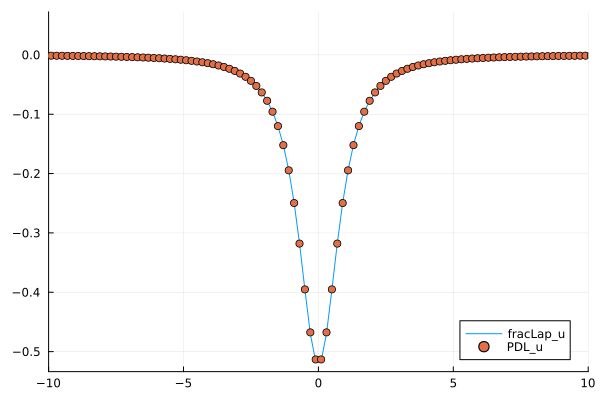

In [35]:
x = range(-1000, 1000, length = 10000)
println("HI")
h = x[2] - x[1]
α = 1.5
u = (x) -> (1+x^2)^(-(1-α)/2)
fracLap_u = (x) -> 2^α * gamma((1+α)/2)/gamma((1-α)/2) * (1+x^2)^(-(1+α)/2)
p2 = plot(x, fracLap_u.(x), xlim=(-10,10), label="fracLap_u")

PDL = fft_create_PDL_matrix(10000, α, h, 100) 
PDL_u = PDL*u.(x)

scatter!(p2, x, PDL_u, xlim=(-10,10), label="PDL_u")

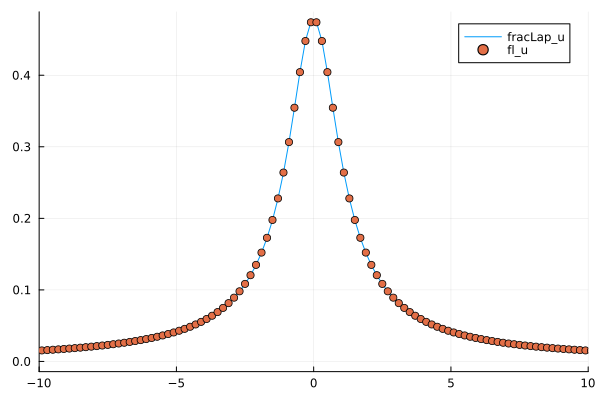

In [30]:
x = range(-1000, 1000, length = 10000)
u = (x) -> (1+x^2)^(-(1-α)/2)
u_test = u.(x)

fracLap_u = (x) -> 2^α * gamma((1+α)/2)/gamma((1-α)/2) * (1+x^2)^(-(1+α)/2)

p2 = plot(x, fracLap_u.(x), xlim=(-10,10), label="fracLap_u")
fl_u = fractional_Laplacian_vec(u_test, α, h, 10000, u_test[1])

scatter!(p2, x, fl_u, xlim=(-10,10), label="fl_u")

In [58]:
println("size(PDL_u): ", size(PDL_u))